In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import gdreg
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests


# autoreload
%load_ext autoreload
%autoreload 2

### Trait info

In [2]:
DIC_NAME = {
    'blood_PLATELET_COUNT': 'Platelet Count', 
    'blood_RBC_DISTRIB_WIDTH': 'Red Blood Cell Distribution Width',
    'blood_RED_COUNT': 'Red Blood Cell Count',
    'blood_WHITE_COUNT': 'White Blood Cell Count', 
    'bmd_HEEL_TSCOREz': 'Heel T Score', 
    'body_BALDING1': 'Balding Type I', 
    'body_BMIz': 'BMI',
    'body_HEIGHTz': 'Height',
    'body_WHRadjBMIz': 'Waist-hip Ratio',
    'bp_DIASTOLICadjMEDz': 'Diastolic Blood Pressure',
    'cov_EDU_YEARS': 'Years of Education',
    'disease_ALLERGY_ECZEMA_DIAGNOSED': 'Eczema',
    'lung_FEV1FVCzSMOKE': 'FEV1-FVC Ratio',
    'lung_FVCzSMOKE': 'Forced Vital Capacity (FVC)',
    'mental_NEUROTICISM': 'Neuroticism',
    'other_MORNINGPERSON': 'Morning Person',
    'pigment_SUNBURN': 'Sunburn Occasion',
    'repro_MENARCHE_AGE': 'Age at Menarche',
    'repro_MENOPAUSE_AGE': 'Age at Menopause',
    'repro_NumberChildrenEverBorn_Pooled': 'Number Children (Pooled)',
    'cancer_BREAST' : 'Breast Cancer',
    'cancer_PROSTATE' : 'Prostate Cancer',
    'disease_HYPOTHYROIDISM_SELF_REP' : 'Hypothyroidism',
    'biochemistry_AlkalinePhosphatase' : 'Alkaline Phosphatase',
    'biochemistry_AspartateAminotransferase' : 'Aspartate Aminotransferase',
    'biochemistry_Cholesterol' : 'Cholesterol', 
    'biochemistry_Creatinine' : 'Creatinine',
    'biochemistry_IGF1' : 'IGF1',
    'biochemistry_Phosphate' : 'Phosphate',
    'biochemistry_TotalBilirubin' : 'Total Bilirubin',
    'biochemistry_TotalProtein' : 'Total Protein',
    'biochemistry_VitaminD' : 'Vitamin D',
}

In [6]:
# ['Trait Name', 'Trait_Identifier', 'N.ukbimp']
df_info = pd.DataFrame(index=list(DIC_NAME))
df_info['Trait Name'] = [DIC_NAME[x] for x in df_info.index]
df_info['Trait_Identifier'] = df_info.index

trait_list = list(pd.read_csv(
    '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/UKBB_trait/trait_list_all.txt', header=None,
)[0])
df_info = df_info.loc[trait_list].copy()

sumstats_file = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/UKBB_trait/@.sumstats.gz'
df_info['N.ukbimp'] = [pd.read_csv(sumstats_file.replace('@', x), nrows=10, sep='\t')['N'].median()
                for x in df_info.index]
df_info['N.ukbimp'] = df_info['N.ukbimp'].astype(int)

df_info.to_csv('/n/groups/price/martin/data_GDREG/results/tables/trait_info.tsv', sep='\t', index=False)
print('Avg. N = %d' % df_info['N.ukbimp'].mean())

Avg. N = 299410


### Single-SNP annotation info

In [4]:
# [Name, type, reference]
DIC_NAME_AN = {
    'BivFlnk' : ['Flanking bivalent TSS/enhancer', 'b', 'Roadmap Consortium 2015'],
    'Conserved_LindbladToh' : ['Conserved (Lindblad-Toh)', 'b', 'Ward and Kellis 2012'],
    'Conserved_Vertebrate_phastCons46way' : ['Conserved in vertebrates (phastCons)', 'b', 'Siepel et al. 2005'],
    'Conserved_Mammal_phastCons46way' : ['Conserved in mammals (phastCons)', 'b', 'Siepel et al. 2005'],
    'Conserved_Primate_phastCons46way' : ['Conserved in primates (phastCons)', 'b', 'Siepel et al. 2005'],
    'Coding_UCSC' : ['Coding', 'b', 'UCSC'],
    'UTR_3_UCSC' : ['3UTR', 'b', 'UCSC'],
    'UTR_5_UCSC' : ['5UTR', 'b', 'UCSC'],
    'Intron_UCSC' : ['Intron', 'b', 'UCSC'],
    'Enhancer_Andersson' : ['FANTOM5 enhancer', 'b', 'Andersson et al. 2014'],
    'SuperEnhancer_Hnisz' : ['Super enhancer (Hnisz)', 'b', 'Hnisz et al. 2013'],
    'Enhancer_Hoffman' : ['Enhancer', 'b', 'Hoffman et al. 2013'],
    'WeakEnhancer_Hoffman' : ['Weak enhancer', 'b', 'Hoffman et al. 2013'],
    'Promoter_UCSC' : ['Promoter', 'b', 'UCSC'],
    'PromoterFlanking_Hoffman' : ['Promoter flanking', 'b', 'Hoffman et al. 2013'],
    'DHS_Trynka' : ['DHS', 'b', 'Trynka et al. 2013'],
    'DHS_peaks_Trynka' : ['DHS peaks', 'b', 'Trynka et al. 2013'], # In baseline-LF but not in description
    'FetalDHS_Trynka' : ['Fetal DHS', 'b', 'Trynka et al. 2013'],
#     'H3K27ac_Hnisz' : ['H3K27ac (Hnisz)', 'b', 'Hnisz et al. 2013'], 
    'H3K27ac_Hnisz' : ['H3K27ac', 'b', 'Hnisz et al. 2013'], # Originally H3K27ac (Hnisz)
    'H3K27ac_PGC2' : ['H3K27ac (PGC2)', 'b', 'PGC 2014'],
    'H3K4me1_Trynka' : ['H3K4me1', 'b', 'Trynka et al. 2013'],
    'H3K4me1_peaks_Trynka' : ['H3K4me1 peaks', 'b', 'Trynka et al. 2013'], # In baseline-LF but not in description
    'H3K4me3_Trynka' : ['H3K4me3', 'b', 'Trynka et al. 2013'],
    'H3K4me3_peaks_Trynka' : ['H3K4me3 peaks', 'b', 'Trynka et al. 2013'], # In baseline-LF but not in description
    'H3K9ac_Trynka' : ['H3K9ac', 'b', 'Trynka et al. 2013'],
    'H3K9ac_peaks_Trynka' : ['H3K9ac peaks', 'b', 'Trynka et al. 2013'], # In baseline-LF but not in description
    'TFBS_ENCODE' : ['TFBS', 'b', 'ENCODE'],
    'Transcribed_Hoffman' : ['Transcribed', 'b', 'Hoffman et al. 2013'],
    'TSS_Hoffman' : ['TSS', 'b', 'Hoffman et al. 2013'],
    'CTCF_Hoffman' : ['CTCF', 'b', 'Hoffman et al. 2013'],
    'DGF_ENCODE' : ['DGF', 'b', 'ENCODE'],
    'Repressed_Hoffman' : ['Repressed', 'b', 'Hoffman et al. 2013'],
    'Vahedi_Tcell_SE' : ['Super enhancer (Vahedi)', 'b', 'Vahedi et al. 2015'],
    'Vahedi_Tcell_TE' : ['Typical enhancer', 'b', 'Vahedi et al. 2015'],
    'GerpRS_g4' : ['Conserved (GERP RS >= 4)', 'b', 'Davydov et al. 2010'], # from CADD
    'GerpN' : ['Conserved (GERP NS)', 'c', 'Davydov et al. 2010'], # from CADD
    'alleleage' : ['MAF-adjusted predicted allele age', 'c', 'Rasmussen et al. 2014'],
    'LLD_AFR' : ['MAF-adjusted LLD-AFR', 'c', 'Gazal et al. 2017'],
    'nucleotide_div' : ['Nucleotide diversity', 'c', ''],
    'recomb_rate' : ['Recombination rate', 'c', 'HapMap2 map'],
    'Backgrd_Selection_Stat' : ['McVicker B statistics', 'c', 'McVicker et al. 2009'],
    'CpG' : ['CpG content', 'c', ''], # from CADD
    # Non-synonymous removed
    # Synonymous removed
    'CADD_g20' : ['Deleterious (CADD >= 20)', 'b', 'Kircher et al. 2014'],
    'snpeff_nonsynonymous_variant' : ['Non-synonymous', 'b', 'Cingolani et al. 2012'],
    'snpeff_synonymous_variant' : ['Synonymous', 'b', 'Cingolani et al. 2012'],
}

In [6]:
def get_type(line):
    if line == 'b':
        return 'Binary'
    if line == 'c':
        return 'Continuous'

df_info = pd.DataFrame(index=DIC_NAME_AN)
df_info['Name'] = [DIC_NAME_AN[x][0] for x in df_info.index]
df_info['Identifier'] = df_info.index
df_info['Type'] = [get_type(DIC_NAME_AN[x][1]) for x in df_info.index]
df_info['n_snp_common'] = 0
df_info['n_snp_lf'] = 0
df_info['Reference/dataset'] = [DIC_NAME_AN[x][2] for x in df_info.index]

# n_snp
temp_df = pd.read_csv(
    '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/gdreg_res_021023.bsl1k_fct_nocl/'
    'blood_PLATELET_COUNT.tau.tsv', sep='\t', index_col=0
)
for row in df_info.index:
    if df_info.loc[row, 'Type'] == 'Binary':
        df_info.loc[row, 'n_snp_common'] = temp_df.loc['AN:%s_common'%row, 'n_snp']
        df_info.loc[row, 'n_snp_lf'] = temp_df.loc['AN:%s_lf'%row, 'n_snp']
df_info['n_snp_common'] = df_info['n_snp_common'].astype(int)
df_info['n_snp_lf'] = df_info['n_snp_lf'].astype(int)

# Version of the baseline model
df_ldsc = pd.read_excel('/n/groups/price/martin/data_GDREG/results/Gazal_NG_2018_table.xlsx',
                        sheet_name='S1', skiprows=1)
df_ldsc.index = df_ldsc['Main annotation']
df_ldsc.loc[df_ldsc['Version of the baseline model']=='New annotation', 'Version of the baseline model'] = \
    'Gazal et al. 2018' 
df_info['Version of the baseline model'] = [
    df_ldsc.loc[x, 'Version of the baseline model'] 
    if (x in df_ldsc.index) & (x not in ['Non-synonymous', 'Synonymous']) 
    else 'New annotation' 
    for x in df_info['Name']
]

df_info.to_csv('/n/groups/price/martin/data_GDREG/results/tables/annot_info.tsv', sep='\t', index=False)

In [9]:
### baseline-LF
DATA_PATH =  '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001'
with open(DATA_PATH + '/gdreg_res.bsl_fct_100_nocl/blood_PLATELET_COUNT.pickle', 'br') as f:
    temp_df = pickle.load(f)
df_bsl = temp_df['summary']['tau'][['annot', 'type', 'n_snp']].copy()

temp_list = ['AN:all'] + [x for x in df_bsl.index if ('mbin' in x) & ('common' in x)] + \
    [x for x in df_bsl.index if ('mbin' in x) & ('lf' in x)]
temp_list += [x for x in df_bsl.index if (x not in temp_list) & (df_bsl.loc[x, 'type']=='non-binary')]
temp_list += [x for x in df_bsl.index if (x not in temp_list)]
df_bsl = df_bsl.loc[temp_list]

df_bsl.loc[df_bsl['type']=='non-binary', 'n_snp'] = -1
df_bsl['n_snp'] = df_bsl['n_snp'].astype(int)
df_bsl.to_csv('/n/groups/price/martin/data_GDREG/results/tables/baseline_lf_165.tsv', sep='\t', index=False)

### SNP-pair annotation info

In [7]:
# Functional annotations
DATA_PATH =  '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001'
dic_res = {}
with open(DATA_PATH + '/gdreg_res.bsl_fct_100_nocl/blood_PLATELET_COUNT.pickle', 'br') as f:
    dic_res['fct100'] = pickle.load(f)
with open(DATA_PATH + '/gdreg_res.bsl_fct_1k_nocl/blood_PLATELET_COUNT.pickle', 'br') as f:
    dic_res['fct1k'] = pickle.load(f)
DF_ANNOT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

n_annot=45


In [11]:
DIC_NAME_pAN = {
    'proxy_0_100' : ['Proximal 0-100bp', '0-100bp', 'proximity'],
    'proxy_0_1000' : ['Proximal 0-1kb', '0-1kb', 'proximity'],
    'proxy_100_1000' : ['Proximal 100bp-1kb', '100bp-1kb', 'proximity'],
    'exon' : ['Same-exon', 'Same exon', 'gene'],
    'gene' : ['Same-gene', 'Same gene', 'gene'],
    'exonic_gene' : ['Exonic', 'Exonic region of same gene', 'gene'],
    'protein_domain' : ['Same-protein-domain', 'Same protein domain of same gene', 'gene'],
    'cS2G_promoter' : ['Promoter', 'Promoter of same gene', 'gene'],
}

# Functional annotation
for pAN in dic_res['fct100']['summary']['rho'].index:
    pAN = pAN.replace('pAN:','').replace('_common_common','').replace('_lf_lf','')
    if pAN not in DIC_NAME_pAN:
        fct = pAN.replace('_0_100','')
        DIC_NAME_pAN[pAN] = [
            '%s-100'%DF_ANNOT.loc[fct, 'Name'], 
            '%s (0-100bp)' % DF_ANNOT.loc[fct, 'Name'], 'fct-100',
        ]
for pAN in dic_res['fct1k']['summary']['rho'].index:
    pAN = pAN.replace('pAN:','').replace('_common_common','').replace('_lf_lf','')
    if pAN not in DIC_NAME_pAN:
        fct = pAN.replace('_0_1000','')
        if fct not in DF_ANNOT.index:
            print('Missing', fct)
            continue
        DIC_NAME_pAN[pAN] = [
            '%s-1k'%DF_ANNOT.loc[fct, 'Name'], 
            '%s (0-1kb)' % DF_ANNOT.loc[fct, 'Name'], 'fct-1k',
        ]

In [12]:
df_info = pd.DataFrame(index=DIC_NAME_pAN)
df_info['Name'] = [DIC_NAME_pAN[x][0] for x in df_info.index]
df_info['Identifier'] = df_info.index
df_info['Type'] = [DIC_NAME_pAN[x][2] for x in df_info.index]
df_info['n_pair_common_common'] = 0
df_info['n_pair_common_lf'] = 0
df_info['n_pair_lf_lf'] = 0
df_info['avg_dist_common_common'] = 0
df_info['avg_dist_common_lf'] = 0
df_info['avg_dist_lf_lf'] = 0
df_info['avgr_common_common'] = 0
df_info['avgr_common_lf'] = 0
df_info['avgr_lf_lf'] = 0
df_info['Description'] = [DIC_NAME_pAN[x][1] for x in df_info.index]

# n_pair & median distance
STATS_FILE = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/pannot/stats/@.dist.tsv'
for row in df_info.index:
    for mbin in ['common_common', 'common_lf', 'lf_lf']:
        if os.path.exists(STATS_FILE.replace('@', '%s_%s' % (row, mbin))):
            temp_df = pd.read_csv(STATS_FILE.replace('@', '%s_%s' % (row,mbin)), sep='\t')
            temp_df['mid'] = 0.5 * (temp_df['left'] + temp_df['right'])
            temp_df['ct_prop'] = temp_df['count'] / temp_df['count'].sum()
            df_info.loc[row, 'n_pair_%s' % mbin] = temp_df['count'].sum()
            df_info.loc[row, 'avg_dist_%s' % mbin] = (temp_df['mid'] * temp_df['ct_prop']).sum()
            
# avgr 
AVGR_FILE = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/pannot/main.avgr'
temp_df = pd.read_csv(AVGR_FILE, sep='\t', header=None)
temp_df.index = temp_df[0]
for row in df_info.index:
    for mbin in ['common_common', 'common_lf', 'lf_lf']:
        df_info.loc[row, 'avgr_%s' % mbin] = temp_df.loc['pAN:%s_%s' % (row, mbin), 1]
            
df_info.to_csv('/n/groups/price/martin/data_GDREG/results/tables/pannot_info.tsv', sep='\t', index=False)

In [13]:
# Table 1 pannots in baseline-SP
DF_PANNOT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/pannot_info.tsv', sep='\t')
# DF_PANNOT.index = DF_PANNOT['Name']
print("n_pannot=%d" % DF_PANNOT.shape[0])
DF_PANNOT = DF_PANNOT[[
    'Name', 'Description', 'n_pair_common_common', 'n_pair_lf_lf',
    'avg_dist_common_common', 'avg_dist_lf_lf',
]]
for col in ['n_pair_common_common', 'n_pair_lf_lf']:
    DF_PANNOT[col] = ['%0.2fM' % (x/1e6) for x in DF_PANNOT[col]]
for col in ['avg_dist_common_common', 'avg_dist_lf_lf']:
    DF_PANNOT[col] = ['%d' % x for x in DF_PANNOT[col]]
DF_PANNOT.columns = ['Name', 'Description', 'Size (C)', 'Size (LF)', 'Avg. Dist (C)', 'Avg. Dist (LF)']

keep_list = ['Proximal 0-100bp', 'Proximal 0-1kb', 'Same-exon', 'Same-gene', 'Exonic', 'Same-protein-domain', 
             'Promoter', 'H3K27ac-100', 'H3K27ac-1k']
keep_list = ['Proximal 0-1kb', 'Same-exon', 'Same-gene', 'Exonic', 'Same-protein-domain', 'Promoter']
keep_list += [x for x in DF_PANNOT['Name'] if x.endswith('1k')]
print(DF_PANNOT.loc[DF_PANNOT['Name'].isin(keep_list)].to_latex(index=False))

print('100bp pannots')
print((', '.join(DF_PANNOT.loc[[x.endswith('100') for x in DF_PANNOT['Name']], 'Name'])))
print('')
print('1kb pannots')
print((', '.join(DF_PANNOT.loc[[x.endswith('1k') for x in DF_PANNOT['Name']], 'Name'])))

n_pannot=32
\begin{tabular}{llllll}
\toprule
                      Name &                       Description &  Size (C) & Size (LF) & Avg. Dist (C) & Avg. Dist (LF) \\
\midrule
            Proximal 0-1kb &                             0-1kb &    23.62M &     8.46M &           490 &            487 \\
                 Same-exon &                         Same exon &     0.54M &     0.26M &          3598 &           3744 \\
                 Same-gene &                         Same gene &  1367.49M &   521.53M &        392654 &         385553 \\
                    Exonic &        Exonic region of same gene &     1.17M &     0.61M &         52431 &          57013 \\
       Same-protein-domain &  Same protein domain of same gene &     0.09M &     0.09M &         41381 &          54120 \\
                  Promoter &             Promoter of same gene &     0.88M &     0.37M &         44571 &          51104 \\
                    DGF-1k &                       DGF (0-1kb) &     0.85M &     0.34

In [5]:
', '.join()

'DGF-1k, DHS-1k, DHS peaks-1k, Enhancer-1k, Fetal DHS-1k, H3K27ac-1k, H3K27ac (PGC2)-1k, H3K4me1-1k, H3K4me1 peaks-1k, H3K4me3-1k, H3K9ac-1k, Intron-1k, Promoter-1k, Repressed-1k, Super enhancer (Hnisz)-1k, TFBS-1k, Transcribed-1k, Typical enhancer-1k'

In [9]:
# Table 1 pannots
DF_PANNOT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/pannot_info.tsv', sep='\t')
# DF_PANNOT.index = DF_PANNOT['Name']
print("n_pannot=%d" % DF_PANNOT.shape[0])
DF_PANNOT = DF_PANNOT[[
    'Name', 'Description', 'n_pair_common_common', 'n_pair_lf_lf',
    'avg_dist_common_common', 'avg_dist_lf_lf',
]]
for col in ['n_pair_common_common', 'n_pair_lf_lf']:
    DF_PANNOT[col] = ['%0.2fM' % (x/1e6) for x in DF_PANNOT[col]]
for col in ['avg_dist_common_common', 'avg_dist_lf_lf']:
    DF_PANNOT[col] = ['%d' % x for x in DF_PANNOT[col]]
DF_PANNOT.columns = ['Name', 'Description', 'Size (C)', 'Size (LF)', 'Avg. Dist (C)', 'Avg. Dist (LF)']

keep_list = ['Proximal 0-100bp', 'Proximal 0-1kb', 'Same-exon', 'Same-gene', 'Exonic', 'Same-protein-domain', 
             'Promoter', 'H3K27ac-100', 'H3K27ac-1k']
print(DF_PANNOT.loc[DF_PANNOT['Name'].isin(keep_list)].to_latex(index=False))

print('100bp pannots')
print((', '.join(DF_PANNOT.loc[[x.endswith('100') for x in DF_PANNOT['Name']], 'Name'])))
print('')
print('1kb pannots')
print((', '.join(DF_PANNOT.loc[[x.endswith('1k') for x in DF_PANNOT['Name']], 'Name'])))

n_pannot=32
\begin{tabular}{llllll}
\toprule
                Name &                        Description &  Size (C) & Size (LF) & Avg. Dist (C) & Avg. Dist (LF) \\
\midrule
    Proximal 0-100bp &                            <100 bp &     2.62M &     0.98M &            47 &             46 \\
      Proximal 0-1kb &                              <1 kb &    23.62M &     8.46M &           490 &            487 \\
           Same-exon &                          Same exon &     0.54M &     0.26M &          3598 &           3744 \\
           Same-gene &                          Same gene &  1367.49M &   521.53M &        392654 &         385553 \\
              Exonic &         Exonic region of same gene &     1.17M &     0.61M &         52431 &          57013 \\
 Same-protein-domain &  Same protein domain and same gene &     0.09M &     0.09M &         41381 &          54120 \\
            Promoter &              Promoter of same gene &     0.88M &     0.37M &         44571 &          51104 \\
  

### Old code

In [25]:
PGEN_FILE = '/n/scratch3/users/j/jz286/imp_geno/ukb_imp_chr22_v3'
PANNOT = 'cS2G_promoter'

# df_snp_chr
df_snp_chr = gdreg.util.read_pgen(PGEN_FILE)["pvar"]
df_snp_chr = df_snp_chr[["CHR", "SNP", "BP"]].copy()
CHR = df_snp_chr["CHR"][0]
df_snp_chr['MAF'] = gdreg.util.read_pgen(PGEN_FILE)["afreq"]["MAF"].astype(np.float32)
dic_bp = {x:y for x,y in zip(df_snp_chr["SNP"], df_snp_chr["BP"])}
print('#########')
print('df_snp_chr', df_snp_chr.shape)
print(df_snp_chr.iloc[:3]) 

# df_cs2g
df_cs2g = pd.read_csv(
    '/n/groups/price/martin/data_GDREG/gene_annotation/cS2G/cS2G_UKBB/cS2G.%s.SGscore.gz' % CHR, sep='\t',
)
df_snpmap = pd.read_csv(
    '/n/groups/price/martin/data_GDREG/gene_annotation/cS2G/00_bim/UKBB.%s.info' % CHR, sep=' ',
)

temp_dic = {x:y for x,y in zip(df_snpmap['ID'], df_snpmap['RS'])}
df_cs2g['ID'] = df_cs2g['SNP']
df_cs2g['SNP'] = [temp_dic[x] for x in df_cs2g['ID']]

df_cs2g['Link'] = df_cs2g['cS2G'] > 0.5
df_cs2g['Exon'] = np.array(['Exon' in x for x in df_cs2g['INFO']]) & df_cs2g['Link']
df_cs2g['Promoter'] = np.array(['Promoter' in x for x in df_cs2g['INFO']]) & df_cs2g['Link']
df_cs2g['Other'] = (~df_cs2g['Exon']) & (~df_cs2g['Promoter']) & df_cs2g['Link']
print('#########')
print('df_cs2g', df_cs2g.shape)
print('Overlap with df_snp_chr:', len(set(df_snp_chr['SNP']) & set(df_cs2g['SNP'])))
print(df_cs2g.iloc[:3]) 
print(df_cs2g[['Link', 'Exon', 'Promoter', 'Other']].sum(axis=0))

#########
df_snp_chr (199680, 4)
   CHR          SNP        BP       MAF
0   22  rs587769434  16050527  0.001391
1   22   rs62224609  16051249  0.100340
2   22   rs62224614  16053862  0.101977
#########
df_cs2g (113016, 9)
Overlap with df_snp_chr: 68926
                  SNP   GENE  cS2G     INFO                  ID  Link  Exon  \
0         rs556077431  POTEH   1.0  |Exon=1     22:16258211_A_G  True  True   
1  22:16258290_CATT_C  POTEH   1.0  |Exon=1  22:16258290_CATT_C  True  True   
2         rs200891952  POTEH   1.0  |Exon=1     22:16258294_T_G  True  True   

   Promoter  Other  
0     False  False  
1     False  False  
2     False  False  
Link        87789
Exon        13072
Promoter    11038
Other       63679
dtype: int64


In [29]:
# cS2G SNP pairs    
if PANNOT == 'cS2G_all':
    ind_select = df_cs2g['Link']

if PANNOT == 'cS2G_promoter':
    ind_select = df_cs2g['Link'] & df_cs2g['Promoter']

if PANNOT == 'cS2G_other':
    ind_select = df_cs2g['Link'] & df_cs2g['Other']

temp_df = df_cs2g.loc[ind_select].copy()
temp_df = temp_df.loc[temp_df['SNP'].isin(df_snp_chr['SNP'])]
# temp_df = temp_df.groupby('GENE').agg({'SNP':list})  

In [32]:
temp_df.index = temp_df['SNP']

In [38]:
df_snp = df_snp_chr.copy()
df_snp.index = df_snp['SNP']
df_snp = df_snp.join(temp_df[['GENE', 'cS2G', 'INFO', 'ID', 'Link', 'Exon', 'Promoter', 'Other']])

In [40]:
df_snp = df_snp.loc[~df_snp['Promoter'].isna()]

In [41]:
df_snp

,CHR,SNP,BP,MAF,GENE,cS2G,INFO,ID,Link,Exon,Promoter,Other
SNP,,,,,,,,,,,,
22:17101208_TG_T,22,22:17101208_TG_T,17101208,0.269351,TPTEP1,1.0,|Promoter=1,22:17101208_TG_T,True,False,True,False
22:17301606_AC_A,22,22:17301606_AC_A,17301606,0.129504,XKR3,1.0,|Promoter=1,22:17301606_AC_A,True,False,True,False
22:17302415_AT_A,22,22:17302415_AT_A,17302415,0.119405,XKR3,1.0,|Promoter=1|ABC=1,22:17302415_AT_A,True,False,True,False
22:17488801_TC_T,22,22:17488801_TC_T,17488801,0.001602,GAB4,1.0,|Promoter=1|Cicero=1,22:17488801_TC_T,True,False,True,False
22:17679877_GAA_G,22,22:17679877_GAA_G,17679877,0.042018,CECR1,1.0,|Promoter=1|ABC=1,22:17679877_GAA_G,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
rs986643,22,rs986643,22397907,0.393497,PRAMENP,1.0,|Promoter=1|GTeX_Finemapped=1|eQTLGen_Finemapp...,22:22397907_T_C,True,False,True,False
rs986644,22,rs986644,22397943,0.042051,PRAMENP,1.0,|Promoter=1,22:22397943_C_G,True,False,True,False
rs986645,22,rs986645,22398127,0.393269,PRAMENP,1.0,|Promoter=1|GTeX_Finemapped=1|eQTLGen_Finemapp...,22:22398127_C_T,True,False,True,False


In [50]:
df_exon = pd.read_csv(
    "/n/groups/price/martin/data_GDREG/gene_annotation/ENSE_exon_annot_v41.txt", sep="\t"
)

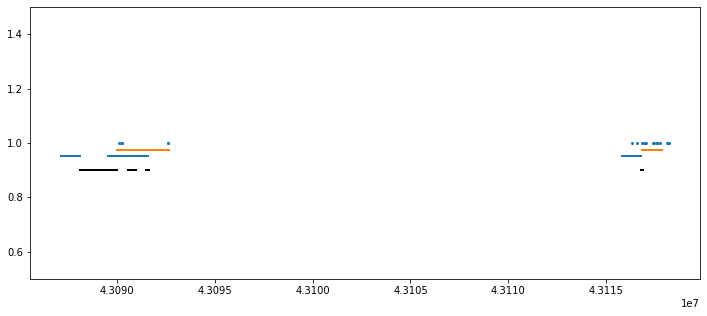

In [81]:
gene = 'A4GALT'
df_plot = df_snp.loc[df_snp['GENE']==gene]

plt.figure(figsize=[12, 5])
plt.scatter(df_plot['BP'], [1]*df_plot.shape[0], s=4)
for ind in df_exon.index[df_exon['GENE_NAME']==gene]:
    plt.plot([df_exon.loc[ind, 'START'], df_exon.loc[ind, 'END']], [0.9, 0.9], color='k', linewidth=2)
    plt.plot([df_exon.loc[ind, 'START']-1000, df_exon.loc[ind, 'START']], [0.95, 0.95], color='C0', linewidth=2)
    plt.plot([df_exon.loc[ind, 'END'], df_exon.loc[ind, 'END']+1000], [0.975, 0.975], 
             color='C1', linewidth=2)
plt.ylim([0.5, 1.5])
# plt.xlim([4.3115e7,4.3119e7])
plt.show()

In [80]:
df_exon.loc[df_exon['GENE_NAME']==gene]

,CHR,START,END,ENSE,ENSG,GENE_TYPE,GENE_NAME
296156,chr22,43088127,43090003,ENSE00001488045,ENSG00000128274,protein_coding,A4GALT
296157,chr22,43090549,43090992,ENSE00001557395,ENSG00000128274,protein_coding,A4GALT
296158,chr22,43091497,43091637,ENSE00003825309,ENSG00000128274,protein_coding,A4GALT
296159,chr22,43116803,43116876,ENSE00003820895,ENSG00000128274,protein_coding,A4GALT
296160,chr22,43088128,43090003,ENSE00000880583,ENSG00000128274,protein_coding,A4GALT
296161,chr22,43091497,43091639,ENSE00001109573,ENSG00000128274,protein_coding,A4GALT
296162,chr22,43091581,43091637,ENSE00001559732,ENSG00000128274,protein_coding,A4GALT
296163,chr22,43116803,43116825,ENSE00003818792,ENSG00000128274,protein_coding,A4GALT


In [46]:
temp_df = df_snp.groupby('GENE').agg({'BP':list})  
for gene in temp_df.index:
    if np.std(temp_df.loc[gene, 'BP']) > 10000:
        print(gene)

A4GALT
AP1B1
ARHGAP8
ARVCF
ASCC2
ATP6V1E1
ATXN10
BCL2L13
BCR
BRD1
CABIN1
CACNA1I
CACNG2
CDC45
CECR2
CELSR1
CERK
CHEK2
CLTCL1
CSNK1E
DEPDC5
DGCR2
DGCR5
DGCR8
EFCAB6
EIF4ENIF1
EMID1
FAM118A
FAM19A5
FBLN1
GGT1
GRAMD4
GRAP2
GTPBP1
GTSE1
IL2RB
KIAA0930
KIAA1671
KLHL22
LARGE
LIMK2
LRP5L
MED15
MEI1
MICAL3
MICALL1
MKL1
MORC2
MOV10L1
MTMR3
MYH9
MYO18B
NDUFA6-AS1
OSBP2
PACSIN2
PARVB
PI4KA
PI4KAP2
PISD
PITPNB
PLA2G6
PLXNB2
POLR2F
PPARA
PPIL2
PPP6R2
PRR5
RBFOX2
RFPL1S
RNF215
SCUBE1
SEZ6L
SFI1
SGSM1
SMTN
SPECC1L
SREBF2
SYN3
TAB1
TANGO2
TBC1D10A
TCF20
TMEM184B
TNRC6B
TPST2
TRIOBP
TTC28
TTC28-AS1
TTC38
TXNRD2
UPB1
WBP2NL
ZNRF3


In [43]:
temp_df

,BP
GENE,
A4GALT,"[43118163, 43092620, 43090118, 43116929, 43116..."
ACO2,"[41864700, 41865079, 41865809, 41865739, 41865..."
ACR,"[51176855, 51177420, 51176616, 51176004, 51175..."
ADM2,"[50919900, 50919184, 50920618, 50919439, 50919..."
ADORA2A,"[24814772, 24827659, 24820280, 24820094, 24814..."
...,...
ZNF280B,"[22862546, 22864105, 22863768, 22862813, 22864..."
ZNF70,"[24093747, 24094158, 24092758, 24094109, 24093..."
ZNF74,"[20749335, 20748053, 20749042, 20749298, 20747..."


### Old code

In [13]:
df_info = pd.DataFrame(index=DIC_NAME_pAN)
df_info['Name'] = [DIC_NAME_pAN[x][0] for x in df_info.index]
df_info['Identifier'] = df_info.index
df_info['Type'] = [DIC_NAME_pAN[x][2] for x in df_info.index]
df_info['n_pair_common_common'] = 0
df_info['n_pair_common_lf'] = 0
df_info['n_pair_lf_lf'] = 0
df_info['median_dist_common_common'] = 0
df_info['median_dist_common_lf'] = 0
df_info['median_dist_lf_lf'] = 0
df_info['avgr_common_common'] = 0
df_info['avgr_common_lf'] = 0
df_info['avgr_lf_lf'] = 0
df_info['Description'] = [DIC_NAME_pAN[x][1] for x in df_info.index]

# n_pair & median distance
STATS_FILE = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/pannot/stats/@.dist.tsv'
for row in df_info.index:
    for mbin in ['common_common', 'common_lf', 'lf_lf']:
        if os.path.exists(STATS_FILE.replace('@', '%s_%s' % (row,mbin))):
            temp_df = pd.read_csv(STATS_FILE.replace('@', '%s_%s' % (row,mbin)), sep='\t')
            df_info.loc[row, 'n_pair_%s' % mbin] = temp_df['count'].sum()
for row in df_info.index[df_info['Type']=='fct-100']:
    for mbin in ['common_common', 'lf_lf']:
        df_info.loc[row, 'n_pair_%s'%mbin] = \
            dic_res['fct100']['summary']['rho'].loc['pAN:%s_%s'%(row,mbin), 'n_pair']
for row in df_info.index[df_info['Type']=='fct-1k']:
    for mbin in ['common_common', 'lf_lf']:
        df_info.loc[row, 'n_pair_%s'%mbin] = \
            dic_res['fct1k']['summary']['rho'].loc['pAN:%s_%s'%(row,mbin), 'n_pair']
            
# avgr 
AVGR_FILE = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/pannot/main.avgr'
temp_df = pd.read_csv(AVGR_FILE, sep='\t', header=None)
temp_df.index = temp_df[0]
for row in df_info.index:
    for mbin in ['common_common', 'common_lf', 'lf_lf']:
        df_info.loc[row, 'avgr_%s' % mbin] = temp_df.loc['pAN:%s_%s' % (row, mbin), 1]
            
df_info.to_csv('/n/groups/price/martin/data_GDREG/results/tables/pannot_info.tsv', sep='\t', index=False)

In [74]:
# Table 1 pannots
DF_PANNOT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/pannot_info.tsv', sep='\t')
# DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])
DF_PANNOT = DF_PANNOT[['Name', 'Description', 'n_pair_common_common', 'n_pair_lf_lf', 
                       'avgr_common_common', 'avgr_lf_lf']]
for col in ['n_pair_common_common', 'n_pair_lf_lf']:
    DF_PANNOT[col] = ['%0.2fM' % (x/1e6) for x in DF_PANNOT[col]]
for col in ['avgr_common_common', 'avgr_lf_lf']:
    DF_PANNOT[col] = ['%0.3f' % x for x in DF_PANNOT[col]]
DF_PANNOT.columns = ['Name', 'Description', 'Size (C)', 'Size (LF)', 'Avg. LD (C)', 'Avg. LD (LF)']
print(DF_PANNOT.to_latex(index=False))

n_pannot=32
\begin{tabular}{llllll}
\toprule
                      Name &                        Description &  Size (C) & Size (LF) & Avg. LD (C) & Avg. LD (LF) \\
\midrule
          Proximal 0-100bp &                            <100 bp &     2.62M &     0.98M &       0.416 &        0.309 \\
            Proximal 0-1kb &                              <1 kb &    23.62M &     8.46M &       0.364 &        0.249 \\
        Proximal 100bp-1kb &                          100bp-1kb &    21.00M &     7.48M &       0.358 &        0.241 \\
                      Exon &                          Same exon &     0.54M &     0.26M &       0.278 &        0.138 \\
                      Gene &                          Same gene &  1367.49M &   521.53M &       0.065 &        0.047 \\
               Exonic-gene &         Exonic region of same gene &     1.17M &     0.61M &       0.205 &        0.098 \\
            Protein-domain &  Same protein domain and same gene &     0.09M &     0.09M &       0.206 &   

In [ ]:
# Table 1 pannots
DF_PANNOT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/pannot_info.tsv', sep='\t')
# DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])
DF_PANNOT = DF_PANNOT[['Name', 'Description', 'n_pair_common_common', 'n_pair_lf_lf', 
                       'avgr_common_common', 'avgr_lf_lf']]
for col in ['n_pair_common_common', 'n_pair_lf_lf']:
    DF_PANNOT[col] = ['%0.2fM' % (x/1e6) for x in DF_PANNOT[col]]
for col in ['avgr_common_common', 'avgr_lf_lf']:
    DF_PANNOT[col] = ['%0.3f' % x for x in DF_PANNOT[col]]
DF_PANNOT.columns = ['Name', 'Description', 'Size (C)', 'Size (LF)', 'Avg. LD (C)', 'Avg. LD (LF)']
print(DF_PANNOT.to_latex(index=False))

In [39]:
DF_PANNOT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/pannot_info.tsv', sep='\t')
# DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])
DF_PANNOT = DF_PANNOT[['Name', 'Description', 'n_pair_common_common', 'n_pair_lf_lf', 
                       'avgr_common_common', 'avgr_lf_lf']]
for col in ['n_pair_common_common', 'n_pair_lf_lf']:
    DF_PANNOT[col] = ['%0.2fM' % (x/1e6) for x in DF_PANNOT[col]]
for col in ['avgr_common_common', 'avgr_lf_lf']:
    DF_PANNOT[col] = ['%0.3f' % x for x in DF_PANNOT[col]]
DF_PANNOT.columns = ['Name', 'Description', 'Size (C)', 'Size (LF)', 'Avg. LD (C)', 'Avg. LD (LF)']
print(DF_PANNOT.to_latex(index=False))

n_pannot=30
\begin{tabular}{llllll}
\toprule
                      Name &                        Description &  Size (C) & Size (LF) & Avg. LD (C) & Avg. LD (LF) \\
\midrule
          Proximal 0-100bp &                            <100 bp &     2.62M &     0.98M &       0.416 &        0.309 \\
            Proximal 0-1kb &                              <1 kb &    23.62M &     8.46M &       0.364 &        0.249 \\
        Proximal 100bp-1kb &                          100bp-1kb &    21.00M &     7.48M &       0.358 &        0.241 \\
                      Exon &                          Same exon &     0.54M &     0.26M &       0.278 &        0.138 \\
                      Gene &                          Same gene &  1367.49M &   521.53M &       0.065 &        0.047 \\
               Exonic-gene &         Exonic region of same gene &     1.17M &     0.61M &       0.205 &        0.098 \\
            Protein-domain &  Same protein domain and same gene &     0.09M &     0.09M &       0.206 &   

In [19]:
DF_PANNOT

,Name,Description,Type,Size (C),Size (LF),Avg. LD (C),Avg. LD (LF)
0,Proximal (0-0.1 kb),Within 100 bp,proximity,2621179,981186,0.416440,0.309336
1,Proximal (0-1 kb),Within 1 kb,proximity,23622561,8458072,0.364336,0.248938
2,Proximal (0.1-1 kb),Between 100 bp and 1 kb,proximity,21001382,7476886,0.357821,0.240968
3,Exon,Same exon,gene,542754,262898,0.278384,0.137887
4,Gene,Same gene,gene,1367493711,521528493,0.065348,0.046902
5,Exonic-gene,Exonic region of the same gene,gene,1173399,608234,0.204768,0.097622
6,Protein-domain,Same protein domain and same gene,gene,93951,91867,0.205562,0.072658
7,Promoter,Pairs of promoter SNPs linked to the same gene,gene,877113,365052,0.217566,0.132904
8,H3K27ac (Hnisz)-100,SNP pairs within 100 bp for H3K27ac (Hnisz),fct-100,1975114,756672,0.396433,0.304018
9,H3K27ac (PGC2)-100,SNP pairs within 100 bp for H3K27ac (PGC2),fct-100,1328988,517016,0.386332,0.301221


In [13]:
DF_PANNOT[['Name', 'Type', 'n_pair_common_common', 'n_pair_lf_lf', 'avgr_common_common', 'avgr_lf_lf', 'Description']]

,Name,Type,n_pair_common_common,n_pair_lf_lf,avgr_common_common,avgr_lf_lf,Description
0,Proximal (0-0.1 kb),proximity,2621179,981186,0.416440,0.309336,Within 100 bp
1,Proximal (0-1 kb),proximity,23622561,8458072,0.364336,0.248938,Within 1 kb
2,Proximal (0.1-1 kb),proximity,21001382,7476886,0.357821,0.240968,Between 100 bp and 1 kb
3,Exon,gene,542754,262898,0.278384,0.137887,Same exon
4,Gene,gene,1367493711,521528493,0.065348,0.046902,Same gene
5,Exonic-gene,gene,1173399,608234,0.204768,0.097622,Exonic region of the same gene
6,Protein-domain,gene,93951,91867,0.205562,0.072658,Same protein domain and same gene
7,Promoter,gene,877113,365052,0.217566,0.132904,Pairs of promoter SNPs linked to the same gene
8,H3K27ac (Hnisz)-100,fct-100,0,0,0.396433,0.304018,SNP pairs within 100 bp for H3K27ac (Hnisz)
9,H3K27ac (PGC2)-100,fct-100,0,0,0.386332,0.301221,SNP pairs within 100 bp for H3K27ac (PGC2)


### Old code

In [ ]:
# DIC_NAME_pAN = {
#     'proxy_0_100' : ['Proximal (0-0.1 kb)', 'All pairs of SNPs within 100 bp'],
#     'proxy_0_1000' : ['Proximal (0-1 kb)', 'All pairs of SNPs within 1 kb'],
#     'proxy_0_10000' : ['Proximal (0-10 kb)', 'All pairs of SNPs within 10 kb'],
#     'proxy_100_1000' : ['Proximal (0.1-1 kb)', 'All pairs of SNPs between 100 bp and 1 kb'],
#     'proxy_1000_10000' : ['Proximal (1-10 kb)', 'All pairs of SNPs between 1 kb and 10 kb'],
#     'ldp5_proxy_10000' : ['High-LD', 'All pairs of SNPs with LD >= 0.5 and dist < 10 kb'],
#     'ldp5_proxy_0_100' : ['High-LD (0-0.1 kb)', 'All pairs of SNPs with LD >= 0.5 and dist < 100 bp'],
#     'ldp5_proxy_100_1000' : ['High-LD (0.1-1 kb)', 
#                              'All pairs of SNPs with LD >= 0.5 and dist between 100 bp and 1 kb'],
#     'ldp5_proxy_1000_10000' : ['High-LD (1-10 kb)', 
#                                       'All pairs of SNPs with LD >= 0.5 and dist between 1 kb and 10 kb'],
#     'exon' : ['Exon', 'All pairs of SNPs in the same exon'],
#     'gene' : ['Gene', 'All pairs of SNPs in the same gene'],
#     'exonic_gene' : ['Exonic-gene', 'All pair of exonic SNPs in the same gene body'],
#     'protein_domain' : ['Protein-domain', 'All pair of SNPs in the same protein domain and same gene'],
#     'cS2G_all' : ['cS2G-all', 'All pairs of SNPs linked to the same gene by cS2G'],
#     'cS2G_promoter' : ['Promoter', 'All pairs of promoter SNPs linked to the same gene'],
#     'cS2G_other' : [
#         'cS2G-other', 
#         'All pairs of other SNPs linked to the same gene by cS2G, excluding exonic or promoter SNPs'],
# }